#Overview & Motivation

The Oscars showcase the best movies released over the past year.  This year, we are a interested in finding out what movies tend to win an Oscar...does it have anything to do with how long the movie is? its genre? when it was released?  We acquired a complete list of all the Oscar nominees and winners from the time of first ever Academy Awards (1927) all the way to 2006.  To scale down the dataset and to make the predictions based off more recent data, we focused on movies from 1981-2006.  This range was chosen as the categories seemed to remain consistent through these years. Our ultimate goal of this project is to take this data, extract features of the movies, and find out exactly what it is that makes a movie Oscar-worthy.  

In [1]:
from imdb import IMDb
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import cPickle as pickle
ia = IMDb(accessSystem='http')
from collections import defaultdict 
import io
from datetime import datetime
import time
import math
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import operator
import sklearn.metrics as metrics

#Related Work
Trying to predict the Oscars is not a completely untouched territory. Movie buffs are constantly updating their predictions on their blogs.  These bloggers are not always using any sort of classifier or maching learning methods to do this, but we assume watching hundrends of movies is not the most efficient way to approach this problem. 

We also found that there were some that there were other attempts to predicting Oscar winners using machine learning techniques (one example can be found at http://cs229.stanford.edu/proj2012/BarberLeODonnell-PredictingThe85thAcademyAwards.pdf).  However we believe our work is unique in that we are trying to answer a more broad question of what types of movies are Oscar worthy (rather than predicting who will win in a specific category).

#Initial Questions

1. Given that a movie is nominated for an Oscar, can we build a classifier that predicts winners?
2. What features are important in this classifier?
3. Do movies tend to win at least one Oscar if nominated for a particular the category?

##Data

To begin answering these questions, we had to search for a reliable source to get a list of Oscar nominated movies.  We found a complete list at http://www.ya-shin.com/awards/awards.html#oscars, but no movie attributes so we could answer our research questions.  To populate our data with some interesting movie features, we used IMDB's python package ([IMDBpy](http://imdbpy.sourceforge.net/)) to access their movie database.  The wrangling and cleaning invovled in the data collection can be found in our oscar_scraper.ipynb here:  https://github.com/oscarpredictor/oscar-predictor/blob/master/oscar_scraper.ipynb.

###Import Data

Because the goal of this aspect of our project is to attempt to predict Oscar winners from those nominated, we first we split our data into a test set (movies in 2005 and 2006) and a training set (movies 1981-2004).  In this analysis, we train our model to predict Oscar winners given that the movie was nominated.

We create a data frame to use for building our classifier, deleting columns with large amounts of missing data and those not related to the analysis. The remaining columns are predictors can effectively choose the winners. 

In [2]:
# Load AAdictfinal (dict of Oscar nominated movies) and convert to DataFrame
AAdf = pd.DataFrame.from_dict(pickle.load(open('AAdictfinal','rb'))).transpose()

In [3]:
dftouse = AAdf.copy()
dftouse.reset_index(level=0, inplace=True)

cols_to_delete = [ u'Won Best Actor',
 u'Won Best Actress',
 u'Won Best Animated Feature Film',
 u'Won Best Art Direction',
 u'Won Best Cinematography',
 u'Won Best Costume Design',
 u'Won Best Director',
 u'Won Best Documentary, Feature',
 u'Won Best Documentary, Short Subject',
 u'Won Best Film Editing',
 u'Won Best Foreign Language Film',
 u'Won Best Makeup',
 u'Won Best Music, Adaptation / Original Song Score',
 u'Won Best Music, Dramatic Score',
 u'Won Best Music, Musical or Comedy Score',
 u'Won Best Music, Original Score',
 u'Won Best Music, Song',
 u'Won Best Picture',
 u'Won Best Short Film, Animated',
 u'Won Best Short Film, Live Action',
 u'Won Best Sound',
 u'Won Best Sound Editing',
 u'Won Best Sound Effects Editing',
 u'Won Best Sound Mixing',
 u'Won Best Supporting Actor',
 u'Won Best Supporting Actress',
 u'Won Best Visual Effects',
 u'Won Best Writing, Adapted Screenplay',
 u'Won Best Writing, Original Screenplay',
 u'Won Special Achievement Award',
 u'Talk-Show',
 u'mpaa',
 u'title',
 u'movieid',
 u'cast',
 u'director',
 u'genres',
 u'countrylist',
 u'keywords',
 u'releasedate',
 u'country',
 u'won',
 u'nominations',
 u'index']
for col in cols_to_delete:
    del dftouse[col]

Now we create a list of the continuous variables in NONINDICATORS and a list of binary variables in INDICATORS.  This will allow us to do exploratory data analysis.  

We also needed to recode the "Nominated XX" columns. When the dataframe was constructed, the categories were coded as 0 if not nominated and name of the nominee if nominated.  We instead converted all "Nominated XX" columns to be 0 if not nominated and 1 if nominated.

In [4]:
# Create a list of indicator variables
NONINDICATORS = set(['month','mpaaint','numnominations','quarter','runtime'])
INDICATORS = set(list(dftouse.columns)) - set(NONINDICATORS)
INDICATORS.remove(u'winner')
INDICATORS.remove('year')

for indicatorcol in INDICATORS:
    # Change strings to booleans
    if u'Nominated' in indicatorcol:
        dftouse[indicatorcol] = dftouse[indicatorcol].apply(lambda x: (type(x)==unicode or type(x)==str or x==True)*1)

Let's a look at part of our final dataframe:

In [5]:
dftouse.head(5)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,France,Germany,History,Horror,Italy,Music,Musical,Mystery,News,Nominated Best Actor,Nominated Best Actress,Nominated Best Animated Feature Film,Nominated Best Art Direction,Nominated Best Cinematography,Nominated Best Costume Design,Nominated Best Director,"Nominated Best Documentary, Feature","Nominated Best Documentary, Short Subject",Nominated Best Film Editing,Nominated Best Foreign Language Film,Nominated Best Makeup,"Nominated Best Music, Adaptation / Original Song Score","Nominated Best Music, Dramatic Score","Nominated Best Music, Musical or Comedy Score","Nominated Best Music, Original Score","Nominated Best Music, Song",Nominated Best Picture,"Nominated Best Short Film, Animated","Nominated Best Short Film, Live Action",Nominated Best Sound,Nominated Best Sound Editing,Nominated Best Sound Effects Editing,Nominated Best Sound Mixing,Nominated Best Supporting Actor,Nominated Best Supporting Actress,Nominated Best Visual Effects,"Nominated Best Writing, Adapted Screenplay","Nominated Best Writing, Original Screenplay",Nominated Special Achievement Award,OtherCountry/Unknown,Romance,Sci-Fi,Short,Spain,Sport,Thriller,USA,War,Western,based-on-novel,blockbuster,blood,character-name-in-title,cigarette-smoking,cult-film,dancing,death,family-relationships,father-daughter-relationship,father-son-relationship,female-nudity,flashback,friendship,husband-wife-relationship,independent-film,love,marriage,month,mother-daughter-relationship,mother-son-relationship,mpaaint,murder,numnominations,quarter,runtime,sex,singing,title-spoken-by-character,violence,winner,year
0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,12,0,0,2,0,1,4,118,0,0,0,0,0,2001
1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,1,5,2,104,0,0,1,0,0,1981
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,11,0,0,0,1,1,4,149,0,0,0,1,0,1981
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,1,3,4,116,0,0,1,0,0,1981
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,60,0,0,0,0,0,1981


#Exploratory Data Analysis


### Relationship between Non-Binary Variables and Outcome

First we look at continuous variables.  Grouping by winners and losers, we should be able to see if any of the continous variables will be good predictors for Oscar winners.  A good predictor will not have overlapping distributions for winners and losers.

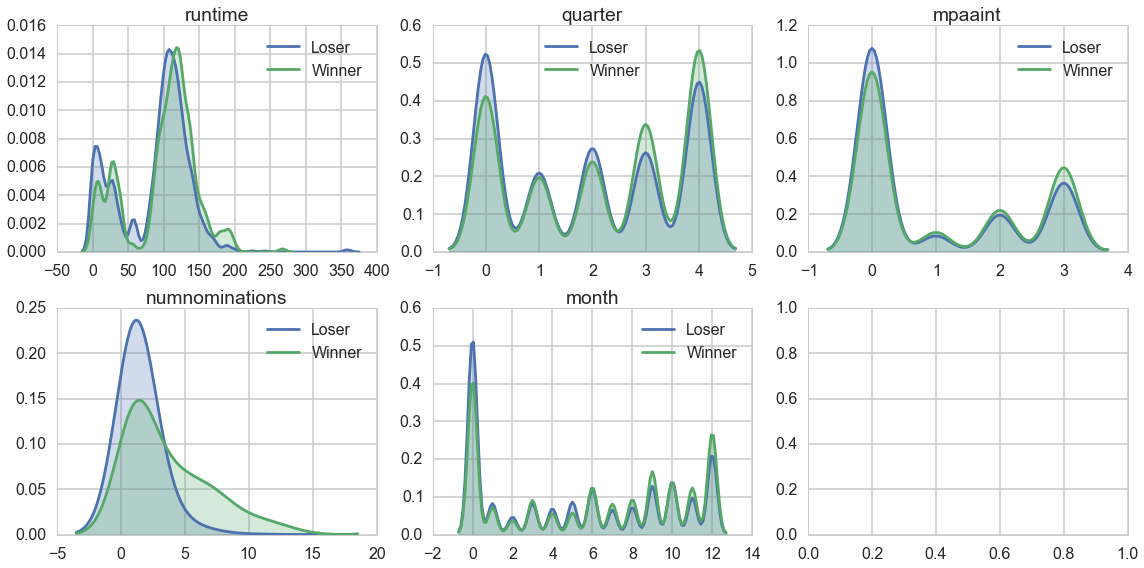

In [7]:
# Code Credit:  HW #3
dfgb=dftouse.groupby('winner')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), NONINDICATORS):
    for k, v in dfgb[p]:
        if k == 0:
            label = "Loser"
        else:
            label = "Winner" 
        if p == 'runtime':
            sns.kdeplot(v, ax=ax, label = label, bw=5, shade = True)
        elif p == 'numnominations':
            sns.kdeplot(v, ax=ax, label = label, bw=1.5, shade = True)
        else:
            sns.kdeplot(v, ax=ax, label = label, bw=0.23, shade = True)
        ax.set_title(p)

####Conclusions

#####Runtime
This might be a good predictor. We see a somewhat bimodal distribution, with peaks forming at approx 0-40 minutes and 100-120 minutes. This can be explained by the fact that there are 2 'Short Film' category awards given out every year. In order to be considered a "short film" by the Academy Awards the runtime must not be greater than 40 minutes, including credits. This means that there is more or less an equal number of 'short films' and an equal number of 'feature-length films' nominated every year, with winners in each. Based on the desnity plot above, it seems that both the Short Films and Feature-Length Films that win tend to be slightly longer in runtime than the average short or feature-length film.

#####Quarter
This also might be a good predictor. Quarter indicates which quarter of the year the movie was released as indicated in IMDBpy (quarter=0 when NA and 1-4 otherwise)  From the plot, we see that given a movie is released in the third (Jul-Sep) and fourth (Oct-Dec) quarter, it is more likely to win an Oscar.

#####MPAAint
MPAA is the parental advisory rating for a movie. Since this is an ordinal variable, we recoded the rating as R=3, PG-13=2, PG=1, and NA=0 (note IMDBpy did not return G ratings). This might be useful for our classifier.  We see that given a movie is rated-R, it is more likely to win. It also seems that movies with a G-rating tend to do poorly in the Oscars, but because our NAs and G-ratings are mixed together, it is difficult to say for sure if this is true.

#####Numnominations
This variable is the number of categories a movie was nominated for.  We would expect that the more a movie is nominated, the more likely it is to win in at least one of those categories, which our plot confirms.

#####Month
This is variable indicates the month in which a movie was released.  Movies released September - December have a slightly higher probability of winning. Therefore this mighte be a useful predictor in our classifier.

### Relationship between Binary Variables and Outcome

Next we look at the indicator variables.  Again, grouping by winners and losers, we should be able to see if any of the continous variables will be good predictors for Oscar winners.  A good predictor will not have overlapping distributions for winners and losers.

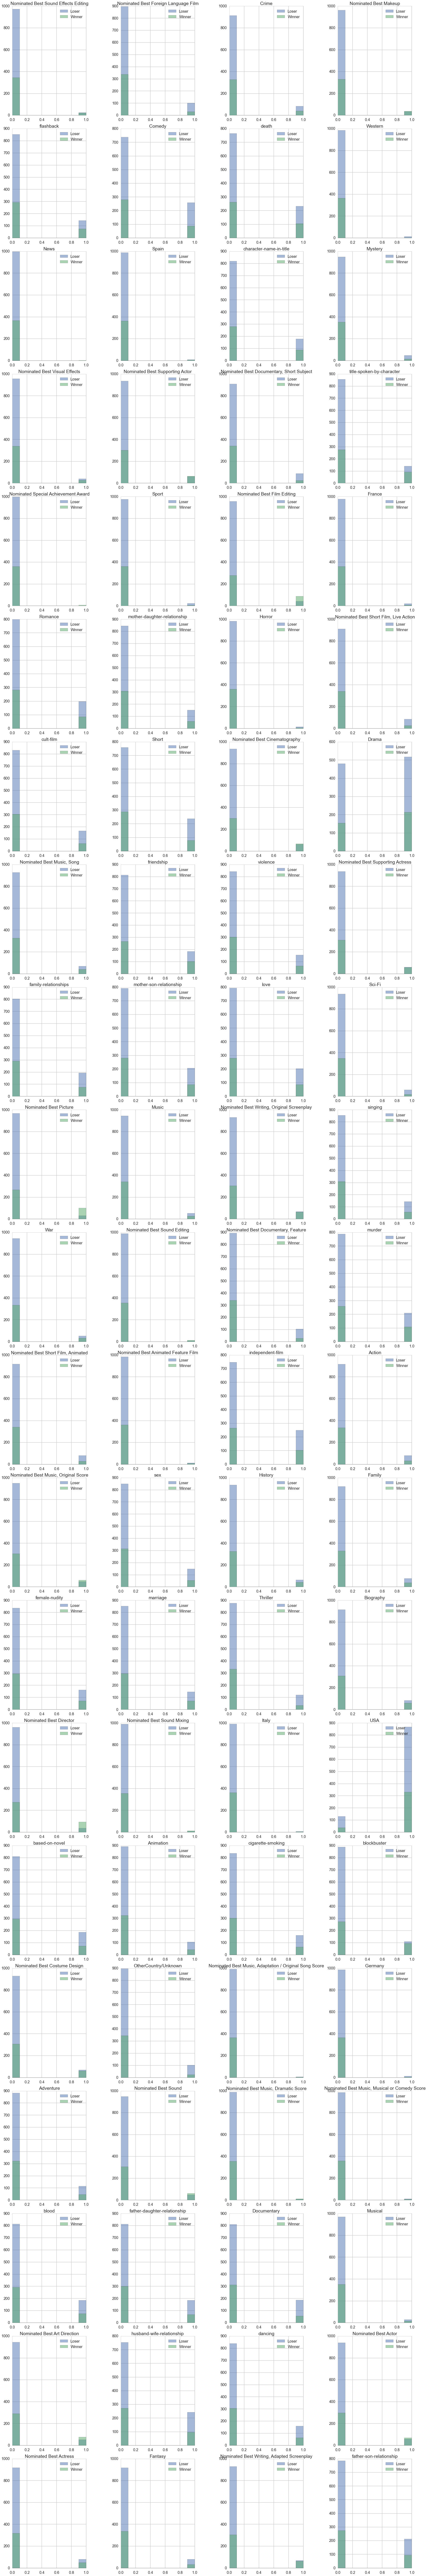

In [8]:
# Code Credit:  HW #3
fig, axes = plt.subplots(nrows=21, ncols=4, figsize=(25,150), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), INDICATORS):
    for k, v in dfgb[p]:
        if k == 0:
            label = "Loser"
        else:
            label = "Winner" 
        v.hist(ax=ax, alpha=0.5, label=label, range = [0,1])
        ax.set_title(p)
        ax.legend()

####Conclusions

#####Nominated Indicators
Nominated categories were coded using dummy variables.  Many of the "Nominated XX" indicators seem to be good predictors.  In particular a movie that is "Nominated Best Picture", "Nominated Best Director", "Nominated Best Sound", "Nominated Best Art Direction", and "Nominated Best Actor" are good indicators of a movie winning. This makes sense because some Oscar categories are more prized and indicative of a 'good' movie. For example, movies nominated for Best Picture are more likely to win an Oscar (even if it's not for Best Picture) than movies nominated for a category like Best Makeup. The categories also mentioned above also contain significant overlap with the coveted 'Big Five' Academy Awards (Best Picture, Best Director, Best Actor, Best Actress, Best Screenplay).

#####Keyword Indicators
Keywords are words used to describe the movie in IMDBpy. In order to reduce dimensionality, just the top 25 most-commonly appearing keywords were coded using dummy variables. The plots did not indicate any keywords being good predictors as there was a lot of overlap across all keywords.

####Country Indicators
The top 5 countries that produce Oscar-nomianted movies (plus an indicator for Other Country) are coded using dummy variables.  Based off the plot, country does not seem to be a good predictor of Oscar winners.

#####Genre Indicators
We used IMDBpy to get the genre for a given movie. Movies may have more than 1 genre. Based off the plot alone, genre does not seem to be a good predictor of Oscar winners. 

It was difficult to tell if some of these indicators would be useful in our classifier. We continued with EDA further investigate.

### More EDA

To continue EDA, we want to look at the following:

1. Countries that tend to win Oscars
2. Frequency of the top 25 keywords among Oscar winners
3. Genres that tend to win Oscars
4. The Release Date (by month) of Oscar Winners

We first get a list of the genres, countries, and keywords in our dataset

In [9]:
%%time

# Get list of unique countries, genres, keywords
# Will be used to create barcharts
genreslist = set()
countries_dict = {}
keywords_dict = {}
for _,movie in AAdf.iterrows():
    for genre in movie.genres:
        genreslist.add(genre)
    if type(movie.countrylist) == list:
        for country in movie.countrylist:
            if country in countries_dict.keys():
                countries_dict[str(country)] += 1
            else:
                countries_dict[str(country)] = 1
    if type(movie.keywords) == list:
        for keyword in movie.keywords:
            if keyword in keywords_dict.keys():
                keywords_dict[keyword] += 1
            else:
                keywords_dict[keyword] = 1
genreslist.remove('Talk-Show')

# shorten countries and keywords dictionary to only most common keywords to reduce dimensionality
numother = 0
for country in countries_dict.keys():
    if countries_dict[country] <= 10:
        numother = numother + countries_dict[country]
        del countries_dict[country]
countries_dict['OtherCountry/Unknown'] = numother
for keyword in keywords_dict.keys():
    if keywords_dict[keyword] <= 200:
        del keywords_dict[keyword]

Wall time: 3min 23s


### Countries with most winners per nominee
In terms of raw numbers, the vast majority of movies that are nominated for and win Academy Awards are from the United States. However, when you look at which countries have the most winning films per nominee (# of winners / # of nominees), the data tells a different story. Italy and Spain edge out the USA in terms of movie success.

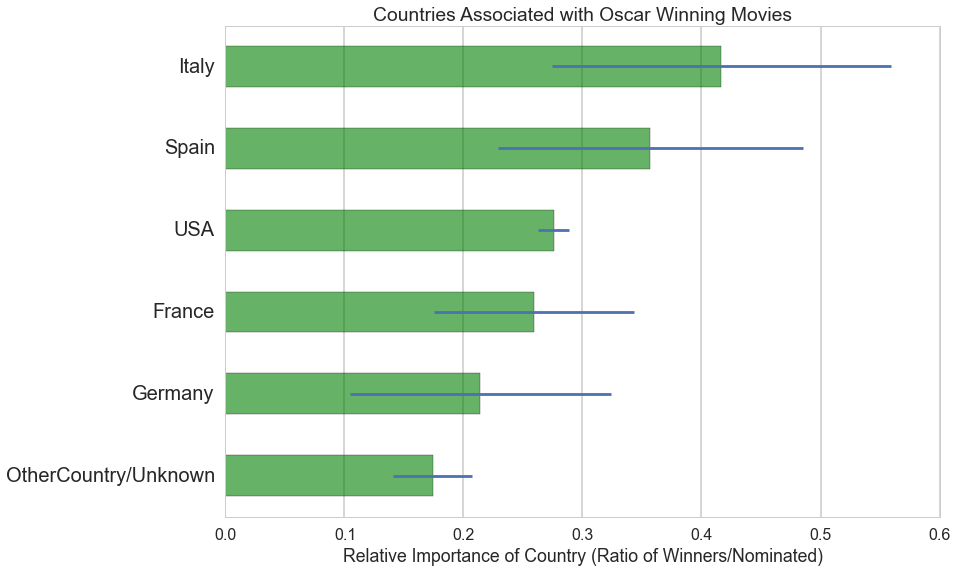

In [13]:
# Create dictionary of countries ratio (winner/total)
countries_dict_ratio = {}
countries_dict_ratiosd = {}
for country in countries_dict.keys():
    countries_dict_ratio[country] = sum(dftouse[dftouse['winner']==1][country]) / float(countries_dict[country])
    countries_dict_ratiosd[country] = np.sqrt((countries_dict_ratio[country] * (1 - countries_dict_ratio[country])) / countries_dict[country])
# Sort countries in order by ratio
sorted_countries = sorted(countries_dict_ratio.items(), key=operator.itemgetter(1))

xerr = []
for key in sorted_countries:
    xerr.append(countries_dict_ratiosd[key[0]])
    
loc1 = [0.5,1.5,2.5,3.5,4.5,5.5]
fig, ax = plt.subplots()
ax.barh(bottom=loc1,width=zip(*sorted_countries)[1],height=0.5, color='g', alpha = .6, align='center', xerr=xerr)
ax.set_ylim(0,6)
ax.set_yticks(loc1)
ax.set_yticklabels(zip(*sorted_countries)[0], size=20)
ax.set_title('Countries Associated with Oscar Winning Movies')
ax.set_xlabel("Relative Importance of Country (Ratio of Winners/Nominated)")
ax.yaxis.grid(False)
ax.legend()
plt.show()

### Most Powerful Plot Elements

Next, we take the ratio of the number of times a keyword is used to describe an Oscar winning movie compared to the overall times a keyword is used to describe an Oscar nominated movie.  We used a bar chart to visually see what keywords could help us identify winners.  Blockbuster and title-spoken-by-character are the top two, and the rest are fairly close within eachother, indicating that most of the keywords might not be helpful in building our classifier.

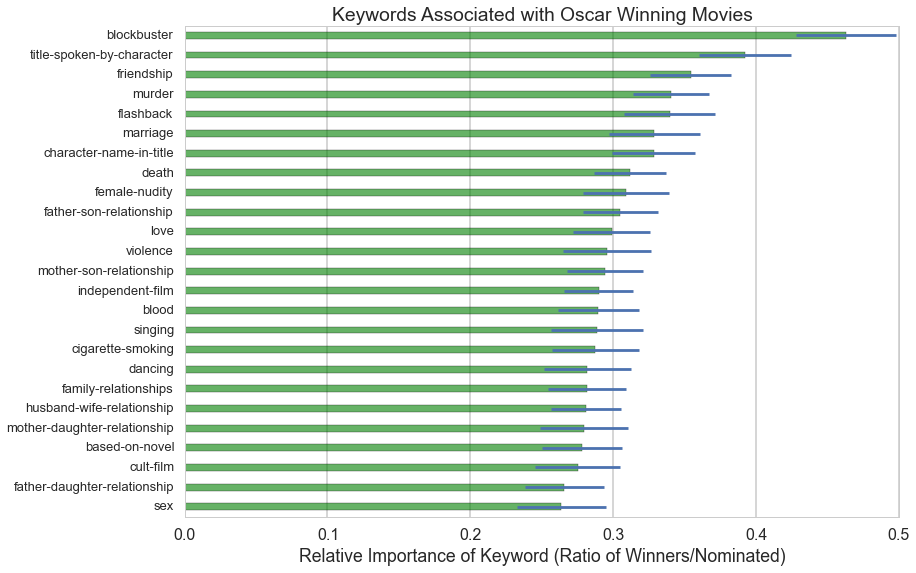

In [16]:
keywords_dict_ratio = {}
keywords_dict_ratiosd = {}
for keyword in keywords_dict.keys():
    keywords_dict_ratio[keyword] = sum(dftouse[dftouse['winner']==1][keyword]) / float(keywords_dict[keyword])
    keywords_dict_ratiosd[keyword] = np.sqrt((keywords_dict_ratio[keyword] * (1 - keywords_dict_ratio[keyword])) / keywords_dict[keyword])
# sort the movie by ratio
sorted_keywords = sorted(keywords_dict_ratio.items(), key=operator.itemgetter(1))

xerr = []
for key in sorted_keywords:
    xerr.append(keywords_dict_ratiosd[key[0]])

loc1 = range(len(sorted_keywords))
fig, ax = plt.subplots()
ax.barh(loc1,zip(*sorted_keywords)[1], 0.35, color='g', label='loser', alpha = .6, align="center",xerr=xerr)
ax.set_ylim(-0.5,24.5)
ax.set_yticks(np.arange(len(zip(*sorted_keywords)[0])))
ax.set_yticklabels(zip(*sorted_keywords)[0], size=13)
ax.set_title("Keywords Associated with Oscar Winning Movies")
ax.set_xlabel("Relative Importance of Keyword (Ratio of Winners/Nominated)")
ax.yaxis.grid(False)
plt.show()

Similar as what we did for keywords, we do for genres. For each genre, we plot the probability of winning given it is nominated and is of a particular genre. It appears that if a movie is of the "News" genre, it will definately win. However this is quite misleading as there was only one "News" movie nominated which happened to win. Following "News" is "Biography", "History", "War", "Musical" and "Music". Therefore if movie has a genre of historical or musical types, it is likely to win, compared to the other genres. If you're looking to make an Oscar-winning film, we advise you stay away from Westerns.

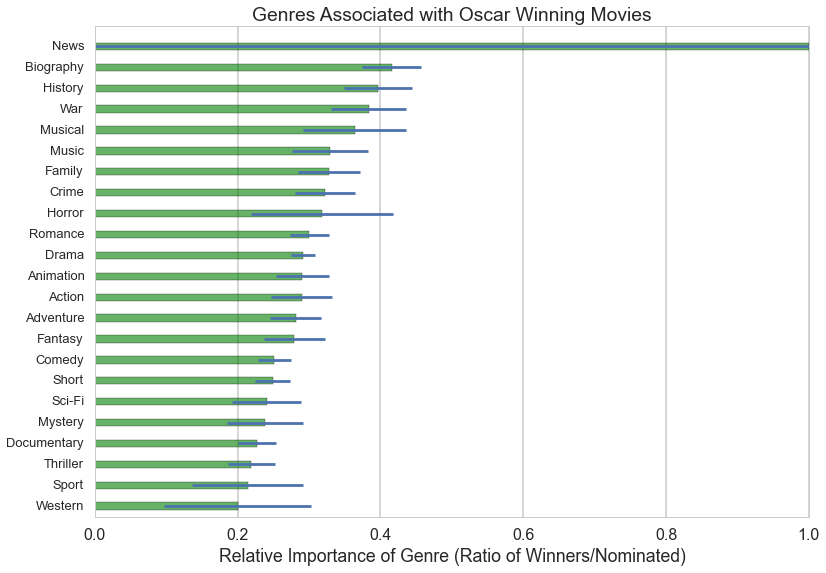

In [17]:
# Create dictionary of genre ratios (winner/total)
genres_dict_ratio = {}
genres_dict_ratiosd = {}
for genre in genreslist:
    genres_dict_ratio[genre] = sum(dftouse[dftouse['winner']==1][genre]) / float(sum(dftouse[genre]))
    genres_dict_ratiosd[genre] = np.sqrt((genres_dict_ratio[genre] * (1 - genres_dict_ratio[genre])) / float(sum(dftouse[genre])))

# sort the movie by ratio
sorted_genres = sorted(genres_dict_ratio.items(), key=operator.itemgetter(1))

xerr = []
for key in sorted_genres:
    sd = genres_dict_ratiosd[key[0]]
    if sd == 0:
        sd = 1
    xerr.append(sd)

loc1 = range(len(sorted_genres))
fig, ax = plt.subplots()
ax.barh(loc1,zip(*sorted_genres)[1], 0.35, color='g', label='loser', alpha = .6, align='center', xerr=xerr)
ax.set_xlim(0,1)
ax.set_ylim(-0.5,len(zip(*sorted_genres)[0]))
ax.set_yticks(np.arange(len(zip(*sorted_genres)[0])))
ax.set_yticklabels(zip(*sorted_genres)[0], size=13)
ax.set_title("Genres Associated with Oscar Winning Movies")
ax.set_xlabel("Relative Importance of Genre (Ratio of Winners/Nominated)")
ax.yaxis.grid(False)
plt.show()

Our earlier EDA indicated that month may be a strong predictor for Oscar winners. We analyzed month of release further in three ways:
1. The raw numbers of the films nominated by release month
2. The raw numbers of the films which won by release month
3. The ratio of films that won to the films nominated by release month

By the raw numbers of nominated films by release month, the bar chart indicates that among the movies even considered for an Oscar, December produces the most nominated-worthy films by a long shot.  We cannot conclude that the release month is driving this phenomenon.  It is possible that the better films are released later in the year purposely.  We wondered if filmmakers purposely release their movies late in the year because the deadline to be considered for an Oscar is December 31.  Audiences have short memories, so this may be a tactic by filmmakers to ensure their movies are still relevant when being considered by the Academy Awards. Another theory is that the release date is motivated by box office sales, as people typically like seeing movies around thd holiday season.

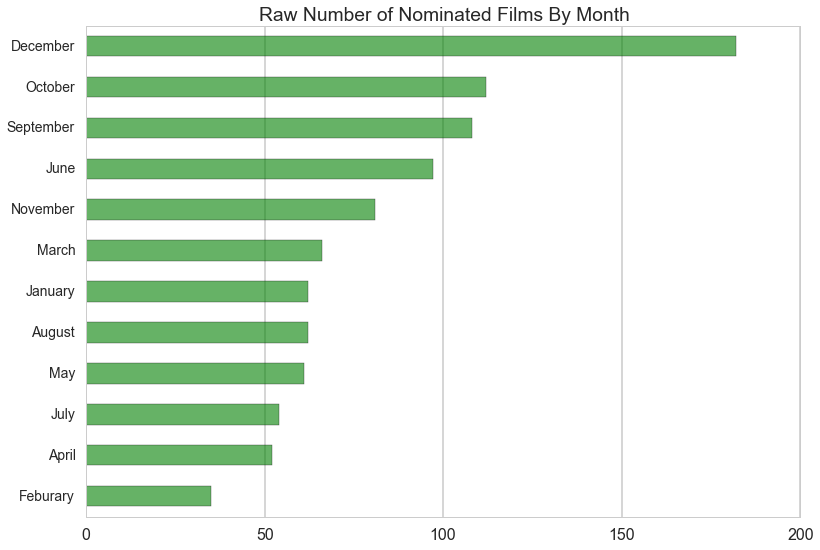

In [18]:
month_name_dict = {0:'Unknown',1:'January',2:"Feburary",3:"March",4:"April",5:"May",6:"June",7:"July",8:"August",9:"September",10:"October",11:"November",12:"December"}
month_dict = {}
for month in range(13):
    month_dict[month_name_dict[month]] = len(dftouse[(dftouse['month']==month)]) 
del month_dict['Unknown']
    
sorted_month_dict = sorted(month_dict.items(), key=operator.itemgetter(1))
    
loc1 = range(len(zip(*sorted_month_dict)[1]))
loc2 = [.35, 1.35,2.35,3.35,4.35,5.35, 6.35, 7.35, 8.35, 9.35,10.35, 11.35]
fig, ax = plt.subplots()
ax.barh(loc1, zip(*sorted_month_dict)[1], 0.5, color='g', alpha = .6, align="center")
ax.set_ylim(-0.5,11.5)
ax.set_yticks(np.arange(len(zip(*sorted_month_dict)[1])))
ax.set_yticklabels(zip(*sorted_month_dict)[0], size=14)
ax.set_title('Raw Number of Nominated Films By Month')
ax.yaxis.grid(False)
plt.show()

Seeing the raw numbers for nominees by  month made us curious of the raw numbers for winners.  December appears to be the best month to release a movie if wanting to win an Oscar.  On the other hand, it may just be that the best movies are released in December. Either way, it's probably best to avoid releasing your next blockbuster on Valentine's Day this year. 

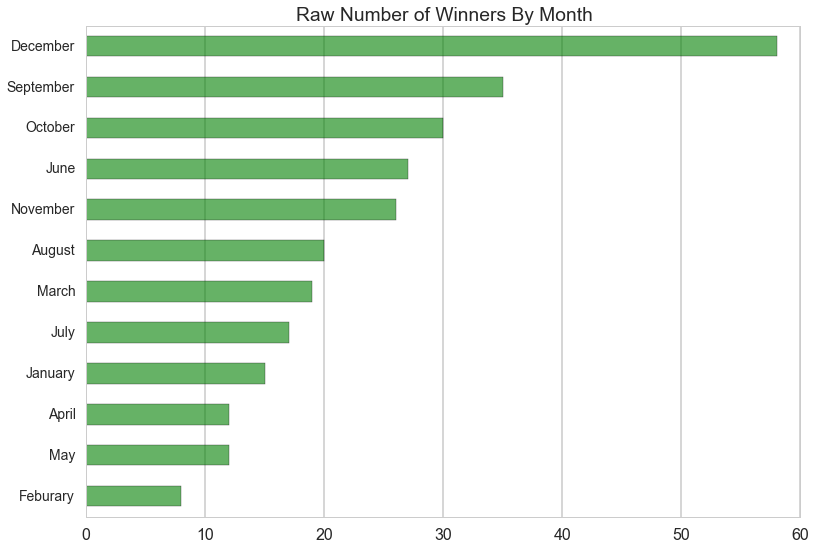

In [19]:
month_dict_winner = {}
for month in range(13):
    month_dict_winner[month_name_dict[month]] = len(dftouse[(dftouse['month']==month) & dftouse['winner']==1])
del month_dict_winner['Unknown']

sorted_month_winners = sorted(month_dict_winner.items(), key=operator.itemgetter(1))

fig, ax = plt.subplots()
ax.barh(loc1, zip(*sorted_month_winners)[1], 0.5, color='g', alpha = .6, align="center")
ax.set_ylim(-0.5,11.5)
ax.set_yticks(np.arange(len(zip(*sorted_month_winners)[1])))
ax.set_yticklabels(zip(*sorted_month_winners)[0], size=14)
ax.set_title('Raw Number of Winners By Month')
ax.yaxis.grid(False)
plt.show()

We decided it may be more telling if we took the ratio of winners released in a particular month to the nominees released in a particular month. Then we can visualize the probability of winning, given the movie was released in a certain month. The order of months shift a bit - now September is at the top, with August, November, December, and July following right behind. However, there is no longer any clear leader. All of our top 5 months fall within each other's standard errors. This might indicate that although November/December have the most nominations and winners, the rate at which movies win in each of those two months isn't much higher than in other months.

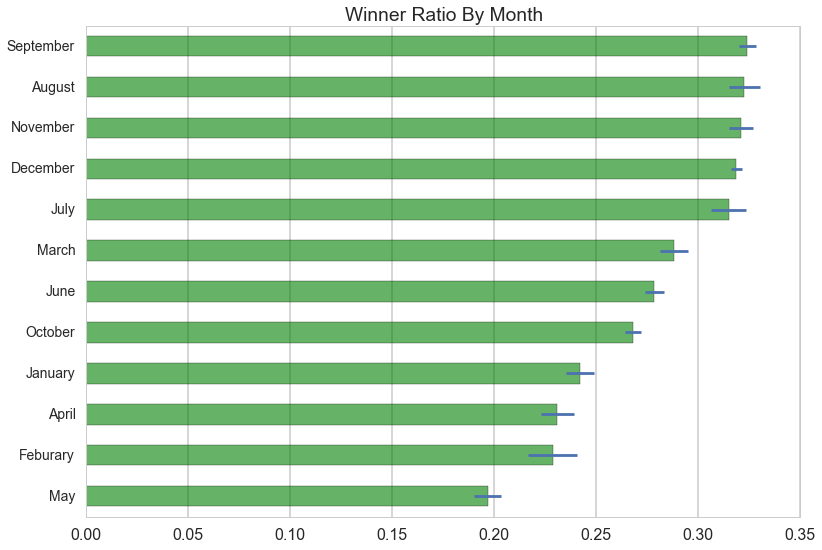

In [20]:
month_dict_ratio = {}
month_dict_ratiosd = {}
for month in range(13):
    month_dict_ratio[month_name_dict[month]] = len(dftouse[(dftouse['month']==month) & dftouse['winner']==1]) / float(sum(dftouse['month']==month))    
    month_dict_ratiosd[month_name_dict[month]] = np.sqrt((month_dict_ratio[month_name_dict[month]] * (1 - month_dict_ratio[month_name_dict[month]]))) / float(sum(dftouse['month']==month))  
del month_dict_ratio['Unknown']

sorted_month_ratio = sorted(month_dict_ratio.items(), key=operator.itemgetter(1))

xerr = []
for key in sorted_month_ratio:
    sd = month_dict_ratiosd[key[0]]
    if sd == 0:
        sd = 1
    xerr.append(sd)

fig, ax = plt.subplots()
ax.barh(loc1, zip(*sorted_month_ratio)[1], 0.5, color='g', label='winner', alpha = .6, align="center", xerr=xerr)
ax.set_ylim(-0.5,11.5)
ax.set_yticks(np.arange(len(zip(*sorted_month_ratio)[1])))
ax.set_yticklabels(zip(*sorted_month_ratio)[0], size=14)
ax.set_title('Winner Ratio By Month')
ax.yaxis.grid(False)
plt.show()

#Predicting Oscar Winners

### Splitting Data and Main Functions
We split into a test set (the movies in the last year in our dataset) and training set. Because we are more focused on predictive accuracy than building any particular model, we will apply many classifiers, using our training data, to build a classifier which predicts Oscar winners. Our idea was to use one or two of each of the most important methods we discussed in class: 

1. Logistic Regression Classifiers (Ridge, LASSO, & Elastic Net)
2. Support Vector Machines (Linear & RBF-Kernel)
3. Ensemble Methods (Random Forests and AdaBoost)

First, we scale our runtime variable for better model-building, and then split our data into training and test sets. 

In [17]:
# scale runtime variable in preparation for model building
from sklearn import preprocessing
dftouse.loc[:,'runtime'] = preprocessing.scale(dftouse['runtime'])

In [18]:
# Test Set:  will be 2005-2006 movies
itest = dftouse.index[dftouse['year']>=2005].copy()
testdf = dftouse[dftouse['year']>=2005].copy()
# Training Set:  1981-2004 movies
itrain = dftouse.index[dftouse['year']<2005].copy()
traindf = dftouse[dftouse['year']<2005].copy()

# create mask for do_classify 
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
lcols = list(INDICATORS) + list(NONINDICATORS)

First we create two functions (with the help of HW3), `cv_optimize` which is passed to our second function `do_classify`.  

The `do_classify` function takes as arguments a classifer `clf`, a dictionary of `parameters` which will be passed to GridSearchCV in order to find the best parameter, the training dataframe `indf`, the list of predictors `featurenames`, the column and value which indicates the winners `targetname` and `target1val`, either an array of if the observation is part of the training set `mask` or as an alternative a dictionary used to provide training and test sets passed in as `reusesplit`, the option to pass in a score function as `score_func`, a default of 5-fold cross validation `n_folds` and the default of 1 for `n_jobs`.

The `cv_optimize` function is used in the `do_classify` function to loop through the `parameters` given using Grid Search. It obtains the best model by the average cross-validation score and returns the best model.

Finally the `do_classify` function fits the training set and test set to the best model found in `cv_optimize`, and returns an accuracy for each.  A confusion matrix is also printed out for the predictions on the test set in order to see how many movies were classified correctly, the number of false positives, and the number of false negatives.

In [19]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_
    best = gs.best_estimator_
    return best

In [77]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, 
                score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask != None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy Score on training data: %0.3f" % (training_accuracy)
    print "Accuracy Score on test data:     %0.3f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

Next we create a function `make_roc`, again with the help of HW3.  

The ROC curve will be useful in determining an appropriate threshold for our classifiers.  The function takes in the parameters the `name` of the classifer, the classifer being used `clf`, the test data `ytest` and `xtext`, `ax`, `labe` to for plotting labels, the parameter `proba` to indicate whether the classifer is probabilisitic, and `skip`.

In [78]:
# Roc curve function, taken from HW3
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

### Baseline Classifiers

Before looking for the best classifier, we want to see how well we would do if we classified all nominees as losers, and all nominiees at winners. These will be our baselines from which we compare the accuracy of later models.

In [79]:
# Baseline: all losers =
testsize = dftouse[~mask].shape[0]
ypred_nowins = np.zeros(testsize, dtype="int")
conf_nowins = confusion_matrix(list(testdf['winner']), ypred_nowins)
print conf_nowins
print "Accuracy on test data:", (float(conf_nowins[0,0]+conf_nowins[1,1])/testsize)

[[80  0]
 [32  0]]
Accuracy on test data: 0.714285714286


In [80]:
# Baseline: all winners = 
ypred_allwins = np.ones(testsize, dtype="int")
conf_allwins = confusion_matrix(list(testdf['winner']), ypred_allwins)
print conf_allwins
print "Accuracy on test data:", (float(conf_allwins[0,0]+conf_allwins[1,1])/testsize)

[[ 0 80]
 [ 0 32]]
Accuracy on test data: 0.285714285714


By classifying all movies as winners we would get 27.6% accuracy, surley we can do better than this.  On the other hand, by classifying all movies as loser we would get 72.4% accuracy!  Accuracy is calculated as the following:

$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.  However, the goal is to predict Oscar winners - accuracy does not seem to be the best way to measure how good we are doing. We can already achieve fairly high accuracy by just predicting every nominee as a loser! Instead we consider recall as a good measurement of how well our classifiers are doing. Recall is the probability of predicting an Oscar winner correctly out of all Oscar winning movies.  Recall is defined as:

$$ Recall = \frac{TP}{TP + FN}$$

Since there are only about a quarter of all nominated movies that win in a year, we want to minimize missing Oscar winners.  However we also do not want a classifier that predicts movies as winners when they are not.  We want a classifier that does not just arbitrarly classifer movies as winners.  For this we consider precision:

$$ Precision = \frac{TP}{TP + FP} $$

A way to combine these two measurements is to use an F1 score to measure how well our classifiers are doing.  F1 can be defined as:
$$ F1 = \frac{precision \cdot recall}{precision + recall} $$

We decide to use F1 to build our classifier.

### Logistic Regression Techniques

#### Logistic Ridge Regression


In [83]:
from sklearn.linear_model import LogisticRegression

clflog_ridge, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l2"),
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                                   indf=dftouse, featurenames=lcols, targetname='winner', 
                                                   target1val=1, mask=mask, score_func='f1')

using mask
BEST {'C': 1.0} 0.488753242452
############# based on standard predict ################
Accuracy Score on training data: 0.814
Accuracy Score on test data:     0.786
[[77  3]
 [21 11]]
########################################################


/Users/Dana/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


It seems that our Ridge Regression does outperform our baselines, with a 78.6% accuracy on the test data. We correctly predict 11 winners, wrongly predict that 3 losers will win, and miss 21 winners that we said would lose.

In [84]:
# reuse our split for later do_classify calls
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

#### Logistic Regression with LASSO



LASSO and Ridge Regression are very similar approaches, but with different penalties for a large number of coefficients. Ridge regression causes features with small effects to have coefficients that tend to 0, while lasso allows for small coefficient values. We will go ahead and try Lasso and compare its results to Ridge Regression.

In [85]:
clflog_lasso, _, _, _, _ = do_classify(LogisticRegression(penalty="l1"),
                                       {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'C': 1.0} 0.489869846227
############# based on standard predict ################
Accuracy Score on training data: 0.809
Accuracy Score on test data:     0.795
[[77  3]
 [20 12]]
########################################################


The results are pretty comparable to Ridge Regression, in terms of accuracy. The only difference is that we correctly predicted one more winner from our test data than we did earlier.

#### Elastic Net Regularized Logistic Regression

We wanted to try an Elastic Net Regularized Regression, which combines that aspects of both ridge and lasso. Scikitlearn does not have an Elastic Net classifier like it does for ridge and lasso regression, so we used an SGD classifier function with a penalty that simulates elastic net. However, our results didn't seem to hold up when compared with the performance of our two previous models.

In [93]:
from sklearn.linear_model import SGDClassifier

clflog_elastic, _, _, _, _ = do_classify(SGDClassifier(loss="log",penalty="elasticnet"), 
                                         {"alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                                          "l1_ratio": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
                                         indf=dftouse, featurenames=lcols, targetname='winner', 
                                         target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'alpha': 0.001, 'l1_ratio': 0.3} 0.536469583608
############# based on standard predict ################
Accuracy Score on training data: 0.799
Accuracy Score on test data:     0.786
[[75  5]
 [19 13]]
########################################################


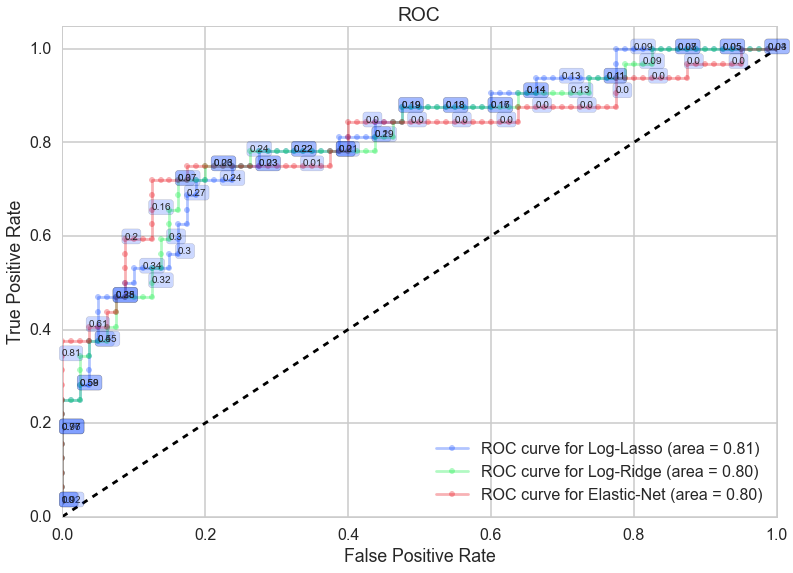

In [94]:
with sns.color_palette("bright"):
    ax = make_roc('Log-Lasso', clflog_lasso, ytest, Xtest)
    make_roc('Log-Ridge', clflog_ridge, ytest, Xtest, ax=ax)
    make_roc('Elastic-Net', clflog_elastic, ytest, Xtest, ax=ax);

Measuring by area under the ROC curve, it looks like the log-lasso model performs the best, but only marginally. It may be difficult to improve the performance of these logistic classifiers unless we obtain more features.

Next, we are repurposing a bit of code from Homework #3 to view the accuracy of our models at different prediction thresholds. This will give us a better idea of how predictive accuracy changes with our thresholds.

In [95]:
def t_repredict_accuracy(clf,t, xtest, ytest):
    probs=clf.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return metrics.accuracy_score(ytest, ypred)

In [96]:
for percent in np.arange(0.30,0.60,0.05):
    print "RidgeReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_ridge,percent,Xtest,ytest)
print ""
for percent in np.arange(0.30,0.60,0.05):
    print "LassoReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_lasso,percent,Xtest,ytest)
print ""
for percent in np.arange(0.30,0.60,0.05):
    print "ElasticReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_elastic,percent,Xtest,ytest)

RidgeReg Accuracy at 0.3 %:  0.785714285714
RidgeReg Accuracy at 0.35 %:  0.785714285714
RidgeReg Accuracy at 0.4 %:  0.776785714286
RidgeReg Accuracy at 0.45 %:  0.794642857143
RidgeReg Accuracy at 0.5 %:  0.785714285714
RidgeReg Accuracy at 0.55 %:  0.785714285714

LassoReg Accuracy at 0.3 %:  0.758928571429
LassoReg Accuracy at 0.35 %:  0.794642857143
LassoReg Accuracy at 0.4 %:  0.8125
LassoReg Accuracy at 0.45 %:  0.794642857143
LassoReg Accuracy at 0.5 %:  0.794642857143
LassoReg Accuracy at 0.55 %:  0.785714285714

ElasticReg Accuracy at 0.3 %:  0.794642857143
ElasticReg Accuracy at 0.35 %:  0.794642857143
ElasticReg Accuracy at 0.4 %:  0.785714285714
ElasticReg Accuracy at 0.45 %:  0.785714285714
ElasticReg Accuracy at 0.5 %:  0.785714285714
ElasticReg Accuracy at 0.55 %:  0.794642857143


This is an interesting result because our accuracy doesn't always change at each 0.05% step in threshold change. This is likely an indication of the relatively small sample size of our test data (just 2 years worth of nominations and winners). That being said, it seems like a maximum accuracy is achieved somewhere just below the 0.5 cutoff. 

###### Analysis of Estimated Coefficients:  Logistic Lasso Model

We consider estimated coefficients with the largest magnitude as the most important predictors.  We see that a variety of our features make the top ten list including nomination categories, genres, and keywords.  

The predictor with the most positive estimated coefficient is "Nominated Special Achievement Award".  A film nominated for this category will increase their probability of winning an Oscar.  On the other hand, a movie that is "Nominated Best Cinematography" has the most negative coefficient of all our predictors.  Therefore, a film nominated for this category decreases their probability of winning an Oscar.

To visualize the influence of our predictors, we plot the estimated coefficients for the Logistic Lasso Model.  Below shows the top 10 most positive and top 10 most negative estimated coefficients in our model.  The coefficients to the right of the red line are features that increase a film's probability of winning an Oscar.  The coefficients to the left of the red line are features that decrease a film's probability of winning an Oscar.

In [97]:
def coefs(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

lasso_importances=coefs(clflog_lasso)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

,abscoef,coef
feature,,
Nominated Special Achievement Award,1.829266,1.829266
Short,0.968286,0.968286
Nominated Best Cinematography,0.937624,-0.937624
War,0.747899,0.747899
numnominations,0.722807,0.722807
Nominated Best Makeup,0.718804,0.718804
Horror,0.663757,0.663757
Nominated Best Costume Design,0.651456,-0.651456
Family,0.631657,0.631657


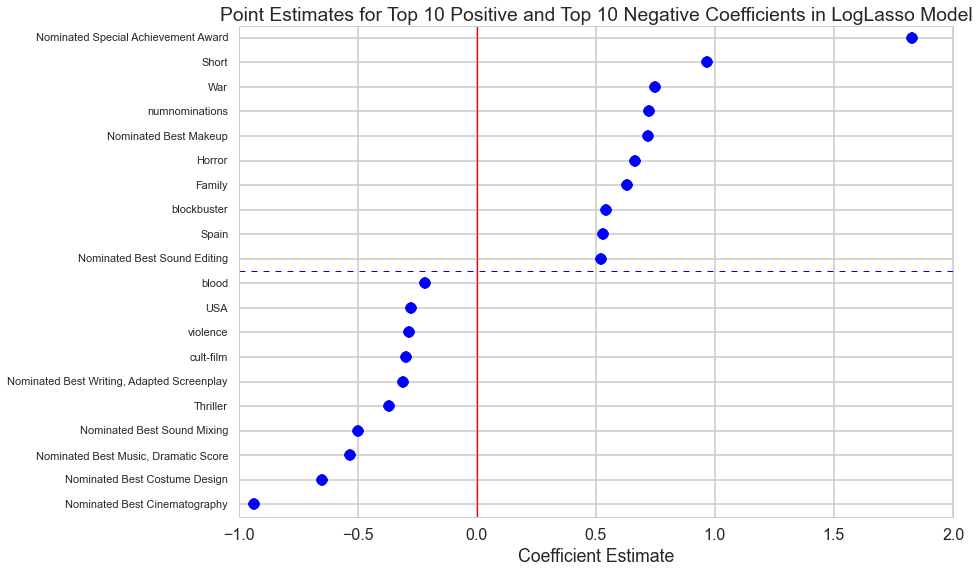

In [98]:
coefsorted = lasso_importances.sort('coef',ascending=False)

toppositive = coefsorted.head(10)
topnegative = coefsorted.tail(10)
tograph = pd.concat([toppositive,topnegative])

fig, ax = plt.subplots()

ax.plot(tograph['coef'][::-1], range(0,20),'bo')
ax.set_ylim(-0.5,19.5);
ax.set_yticks(range(0,20))
ax.set_yticklabels(tograph['coef'][::-1].index, size=11)
ax.set_title('Point Estimates for Top 10 Positive and Top 10 Negative Coefficients in LogLasso Model')
ax.set_xlabel('Coefficient Estimate')
ax.axvline(x=0,color='r',linewidth=1.3)
ax.axhline(y=9.5,color='b',linewidth=1, linestyle='dashed');

###### Analysis of Estimated Coefficients:  Logistic Ridge Regression

We repeat this analysis with our logistic ridge regression model.  Again we see that being nominated for special achievement award increases the probability of a movie winning an Oscar and being nominated for best cinematography decreases the probability of a movie winning an Oscar.  Compared to Logistic Lasso Regression though, we see new top predictors such as "Nominated Best Sound Mixing", "Germany", and "Music".  Overall though there was a lot of overlap between the top predictors for both models.

In [99]:
ridge_importances=coefs(clflog_ridge)
ridge_importances.set_index("feature", inplace=True)
ridge_importances.head(10)

,abscoef,coef
feature,,
Nominated Special Achievement Award,1.311947,1.311947
Nominated Best Cinematography,0.928954,-0.928954
Nominated Best Sound Mixing,0.867438,-0.867438
USA,0.849423,-0.849423
Short,0.792312,0.792312
numnominations,0.789519,0.789519
Nominated Best Costume Design,0.776941,-0.776941
Horror,0.775434,0.775434
War,0.759591,0.759591


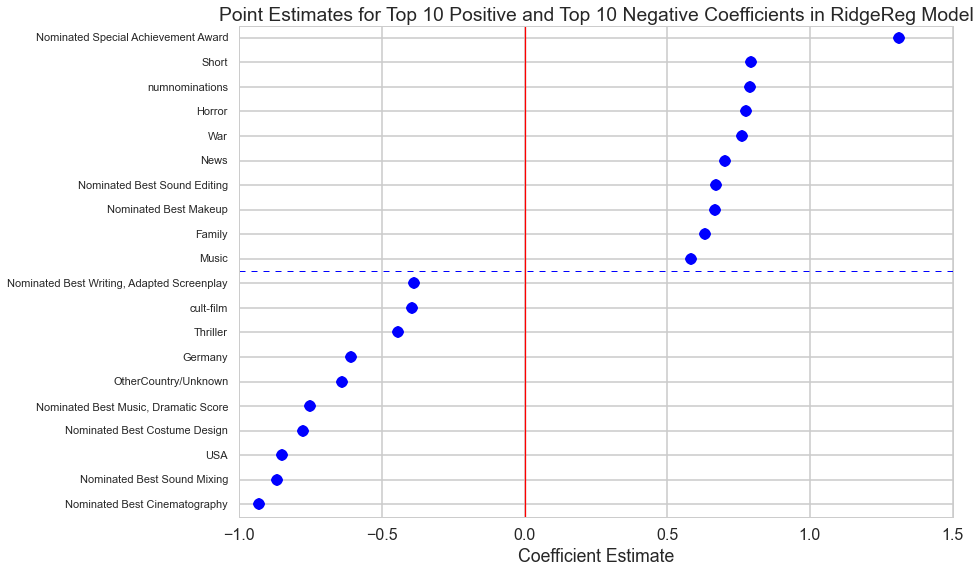

In [100]:
coefsorted2 = ridge_importances.sort('coef',ascending=False)

toppositive2 = coefsorted2.head(10)
topnegative2 = coefsorted2.tail(10)
tograph2 = pd.concat([toppositive2,topnegative2])

fig, ax = plt.subplots()

ax.plot(tograph2['coef'][::-1], range(0,20),'bo')
ax.set_ylim(-0.5,19.5);
ax.set_yticks(range(0,20))
ax.set_yticklabels(tograph2['coef'][::-1].index, size=11)
ax.set_title('Point Estimates for Top 10 Positive and Top 10 Negative Coefficients in RidgeReg Model')
ax.set_xlabel('Coefficient Estimate')
ax.axvline(x=0,color='r',linewidth=1.3)
ax.axhline(y=9.5,color='b',linewidth=1, linestyle='dashed');

### SVM Techniques

After testing out generalized linear model methods above, we wanted to test a different approach to classification. Support Vector Machines are good for large-dimensional data, so we figured they would be the next step in our analysis. However, SVMs can be misfit if the binary data is heavily unbalanced. We will consider balancing the data first.

#### Balance Features

We also wanted to try SVM to predict Oscar winners however SVM does not typically perform well on an unbalanced dataset.  

In [101]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

335 917


We have far more losers than winners in our dataset.  Therefore we will want to balance the dataset before using SVM.

In [102]:
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))

Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((670, 89), (670,))

In [103]:
# create new reuse_split with balanced data
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

We begin with the simplest SVM - a linear kernel. Since we are substantially decreasing our sample size in the balancing of our data, we will test the SVM on the model with balanced data and with unbalanced data.

#### SVM (Linear Kernel) - All Features Balanced

In [119]:
%%time
from sklearn.svm import LinearSVC

clf_linsvmBalanced, _, _, _, _ = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split_new, score_func='f1')

using reuse split
BEST {'C': 0.5} 0.610835950413
############# based on standard predict ################
Accuracy Score on training data: 0.761
Accuracy Score on test data:     0.688
[[58 22]
 [13 19]]
########################################################
CPU times: user 892 ms, sys: 9.52 ms, total: 901 ms
Wall time: 911 ms


#### SVM (Linear Kernel) - All Features Unbalanced

In [108]:
%%time
from sklearn.svm import LinearSVC

clf_linsvm, _, _, _, _ = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'C': 5.0} 0.485794157919
############# based on standard predict ################
Accuracy Score on training data: 0.815
Accuracy Score on test data:     0.777
[[77  3]
 [22 10]]
########################################################
CPU times: user 2.1 s, sys: 12.2 ms, total: 2.12 s
Wall time: 2.13 s


It seems that it may be better to keep our unbalanced data. From the output above, the loss of so many instances in our balanced data may have reduced our sample size to the point that the model could no longer be fit well. Our unbalanced classifier slightly underperforms the ridge and lasso regressions, predicting a total of 10 winners correctly, falsely predicting 3, and missing 22. 

#### SVM (RBF Kernel) - All Features Balanced

One advantage of an RBF kernel is that it allows for a more flexible model than a linear one (although it may overfit). To see how this kernel performs on our data, we again fit SVMs with our balanced and unbalanced datasets.

In [121]:
%%time
from sklearn.svm import SVC

clf_rbfsvmBalanced, _, _, _, _ = do_classify(SVC(kernel="rbf"),
                                       {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split_new, score_func='f1')

using reuse split
BEST {'C': 100.0} 0.626591452301
############# based on standard predict ################
Accuracy Score on training data: 0.957
Accuracy Score on test data:     0.634
[[52 28]
 [13 19]]
########################################################
CPU times: user 2.52 s, sys: 10.3 ms, total: 2.53 s
Wall time: 2.53 s


#### SVM (RBF Kernel) - All Features Unbalanced

In [110]:
%%time
from sklearn.svm import SVC

clf_rbfsvm, _, _, _, _ = do_classify(SVC(kernel="rbf"),
                                       {"C": [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'C': 10.0} 0.48604943465
############# based on standard predict ################
Accuracy Score on training data: 0.845
Accuracy Score on test data:     0.804
[[77  3]
 [19 13]]
########################################################
CPU times: user 5.92 s, sys: 18.9 ms, total: 5.94 s
Wall time: 5.96 s


In balancing our dataset, we threw away a lot of information and our classifers did not perform as well in predicting in our test data.  For the analysis, we decided to use the SVM classifiers that used the unbalanced data.

Furthermore, it seems that an SVM with an RBF kernel (unbalanced) has the highest performance of any of our models yet. It correctly predicted one more winner than our logistic regression with Lasso, for a test accuracy of 80.4%.

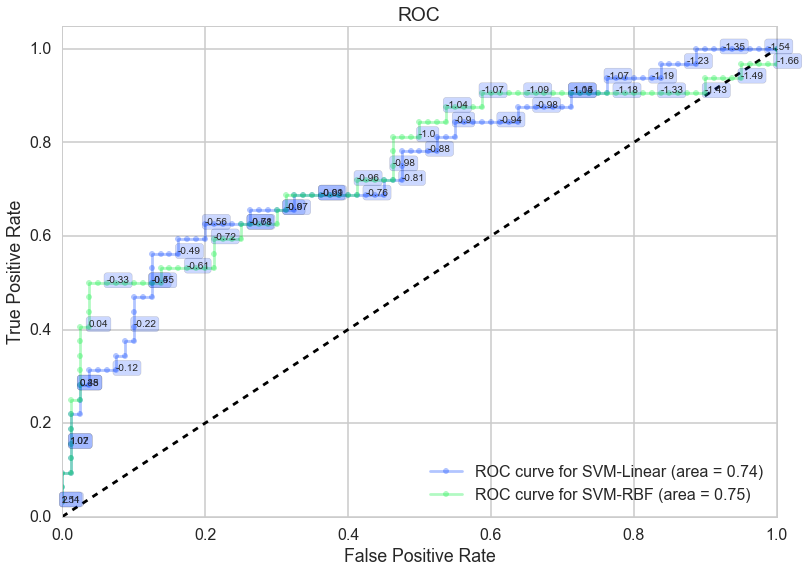

In [112]:
with sns.color_palette("bright"):
    ax2 = make_roc('SVM-Linear', clf_linsvm, ytest, Xtest, proba=False)
    make_roc('SVM-RBF', clf_rbfsvm, ytest, Xtest, ax=ax2, proba=False);

Based on the ROC area-under-the-curve metric, it seems like we have reason to prefer an RBF-kernel to a linear one.

### Ensemble Methods

#### Random Forest Classifier

Random Forest Classifiers use many decision tree classifiers to build a classifier.  The data is randomly subset, a decision tree is built, and this process is repeated many times (10000 times in our case).  Finally the information that is gained through the many decision trees is used to create the random forest classifier.  

In [128]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_randomforest, _, _, _, _ = do_classify(RandomForestClassifier(n_estimators=10000, random_state=0),
                                       {"max_depth": [5,10,15,20,25],"min_samples_split":[5,10,15,20,25]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'min_samples_split': 15, 'max_depth': 25} 0.497156797091
############# based on standard predict ################
Accuracy Score on training data: 0.847
Accuracy Score on test data:     0.812
[[77  3]
 [18 14]]
########################################################
CPU times: user 26min 54s, sys: 13.6 s, total: 27min 7s
Wall time: 27min 30s


Random Forest is our best classifer yet!  We want to see what predictors helped (and what preditors were not so helpful) to make the accuracy so high.  We plotted the 10 most important and 10 least important features.

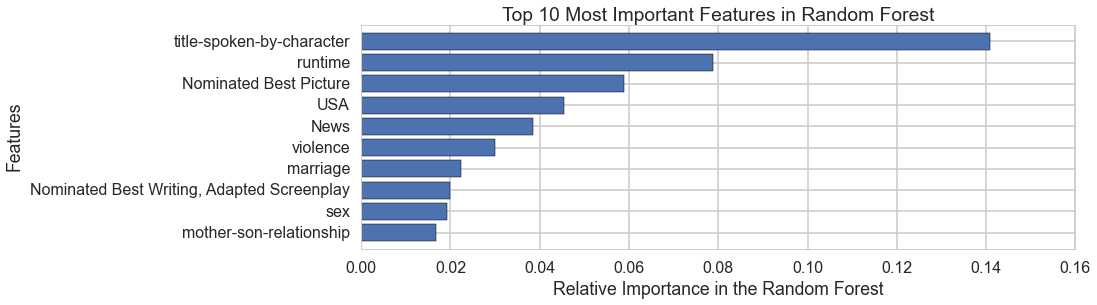

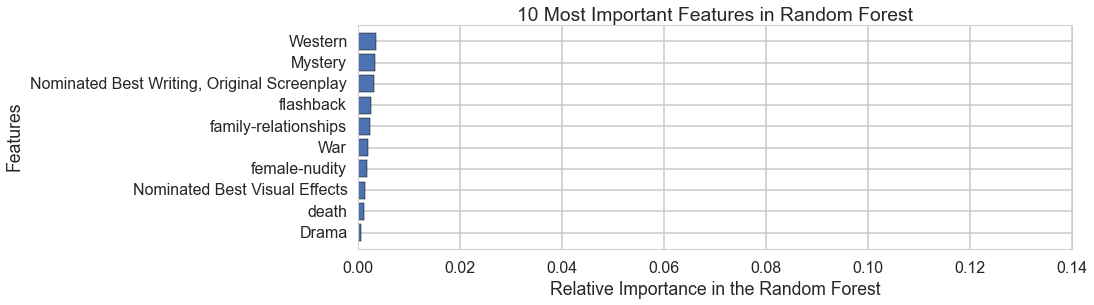

In [129]:
rfimportance_list = clf_randomforest.feature_importances_
rfname_list = dftouse.columns

rfimportance_list, rfname_list = zip(*sorted(zip(rfimportance_list, rfname_list)))
rftopimportance_list = rfimportance_list[len(rfimportance_list)-10:]
rftopname_list = rfname_list[(len(rfname_list)-10):]
rfbottomimportance_list = rfimportance_list[0:10]
rfbottomname_list = rfname_list[0:10]

plt.figure(1)
plt.subplot(211)
plt.barh(range(len(rftopname_list)),rftopimportance_list,align='center')
plt.yticks(range(len(rftopname_list)),rftopname_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.ylim(-0.75,9.75)
plt.title('Top 10 Most Important Features in Random Forest')
plt.show()

plt.subplot(212)
plt.barh(range(len(rfbottomname_list)),rfbottomimportance_list,align='center')
plt.yticks(range(len(rfbottomname_list)),rfbottomname_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.ylim(-0.75,9.75)
plt.xlim(0.00,0.14)
plt.title('10 Most Important Features in Random Forest')
plt.show()

The keyword "title-spoken-by-character" was by far the most important feature in our classifier. The next important features include runtime and whether the movie was nominated for best picture.  It should be noted that this doesn't necessarily mean that these are helpful features to win an Oscar. They could be strongly negatively associated with winners, but it is hard to extract more information from a random forest 'black box.' The least important predictive features include being a 'Drama' genre or having the keyword 'death.' 

#### AdaBoost Classifier

We wanted to try another ensemble method besides Random Forests, so we fit an AdaBoost classifier. 

In [125]:
%%time
from sklearn.ensemble import AdaBoostClassifier

clf_adaboost, _, _, _, _ = do_classify(AdaBoostClassifier(random_state=0), parameters={'n_estimators':range(30,150)},
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, score_func='f1')

using reuse split
BEST {'n_estimators': 117} 0.514010857778
############# based on standard predict ################
Accuracy Score on training data: 0.819
Accuracy Score on test data:     0.795
[[77  3]
 [20 12]]
########################################################
CPU times: user 1min 39s, sys: 356 ms, total: 1min 40s
Wall time: 1min 41s


This model seems to perform more or less on-par with our logistic regressions. Random forest is still our best model in terms of predictive accuracy. 

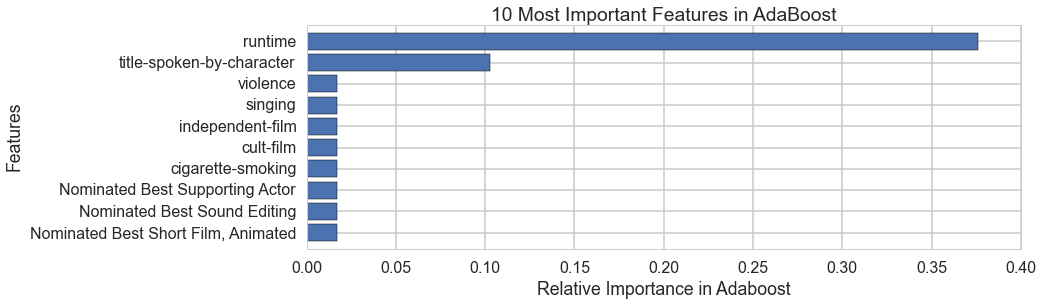

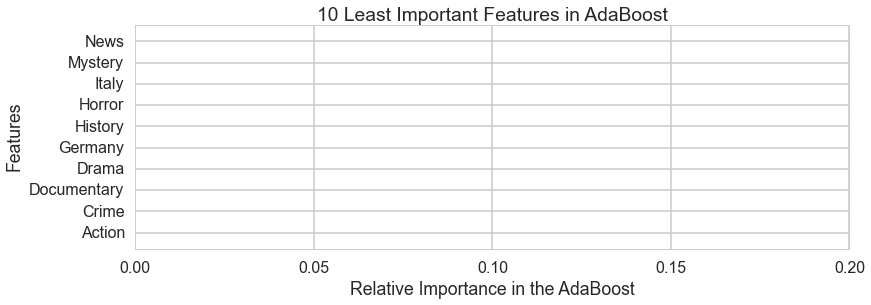

In [126]:
adaimportance_list = clf_adaboost.feature_importances_
adaname_list = dftouse.columns

adaimportance_list, adaname_list = zip(*sorted(zip(adaimportance_list, adaname_list)))
adatopimportance_list = adaimportance_list[len(adaimportance_list)-10:]
adatopname_list = adaname_list[(len(adaname_list)-10):]
adabottomimportance_list = adaimportance_list[0:10]
adabottomname_list = adaname_list[0:10]

plt.figure(1)
plt.subplot(211)
plt.barh(range(len(adatopname_list)),adatopimportance_list,align='center')
plt.yticks(range(len(adatopname_list)),adatopname_list)
plt.xlabel('Relative Importance in Adaboost')
plt.ylabel('Features')
plt.ylim(-0.75,9.75)
plt.title('10 Most Important Features in AdaBoost')
plt.show()

plt.subplot(212)
plt.barh(range(len(adabottomname_list)),adabottomimportance_list,align='center')
plt.yticks(range(len(adabottomname_list)),adabottomname_list)
plt.xlabel('Relative Importance in the AdaBoost')
plt.ylabel('Features')
plt.ylim(-0.75,9.75)
plt.xlim(0.00,0.20)
plt.title('10 Least Important Features in AdaBoost')
plt.show()

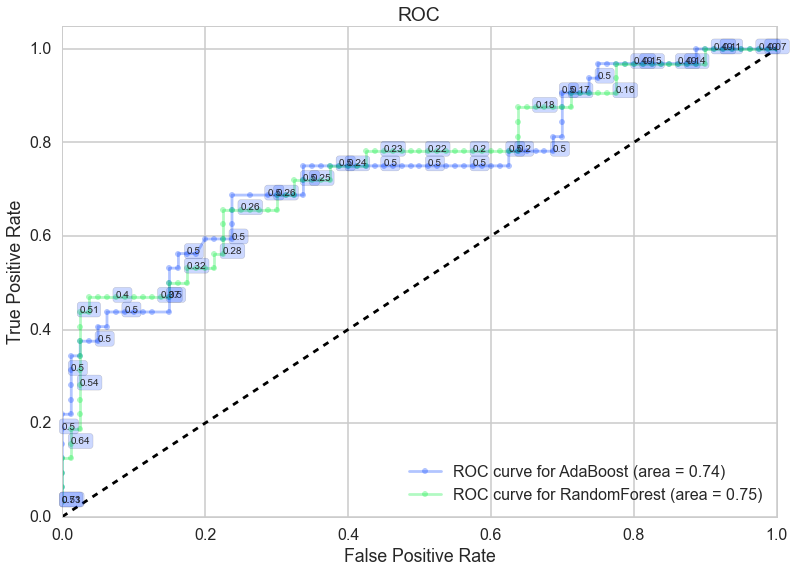

In [130]:
with sns.color_palette("bright"):
    ax3 = make_roc('AdaBoost', clf_adaboost, ytest, Xtest)
    make_roc('RandomForest', clf_randomforest, ytest, Xtest, ax=ax3)

## Decision Surfaces
Now we want to visualize our classifiers using a decision surface.  We chose to plot the decision surface using month and number of nominations because through our EDA and in building our classifiers, we felt these two features were important predictors.  We plot a decision surface for Random Forest, Adaboost, Linear SVM, and RBF-Kernel SVM.  

In [117]:
def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    def jitter(array):
        jittered = []
        for value in array:
            jit = np.random.normal(0.,0.1,1)
            jittered.append(value+jit)
        return np.array(jittered)
    plt.scatter(jitter(X_train[:,0]),jitter(X_train[:,1]),c=pd.Series(Y_train).astype('category'),cmap=plt.cm.Paired)
    plt.show()

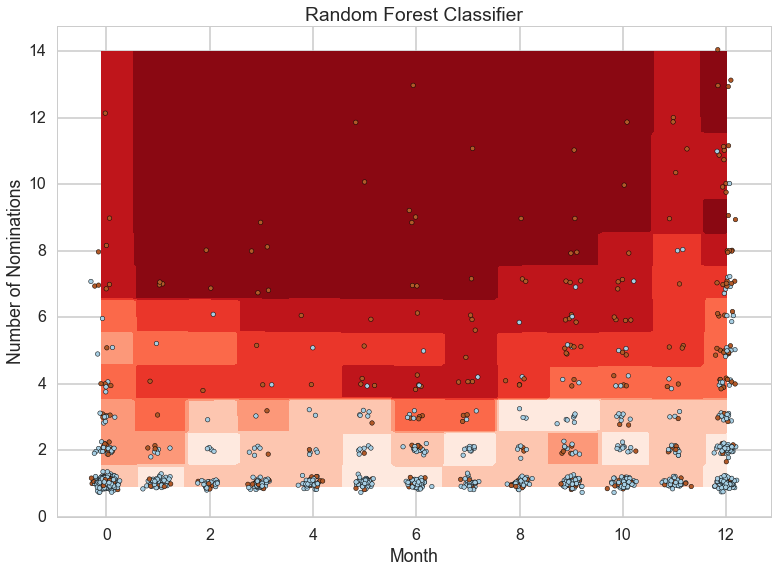

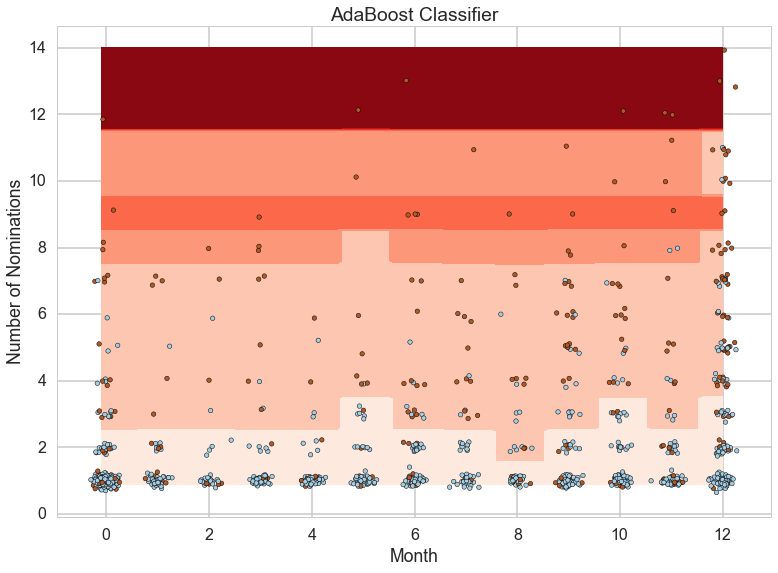

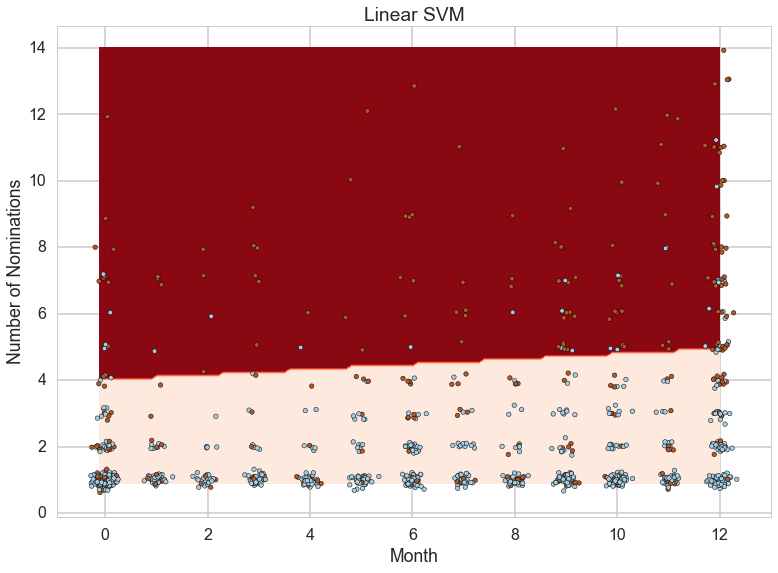

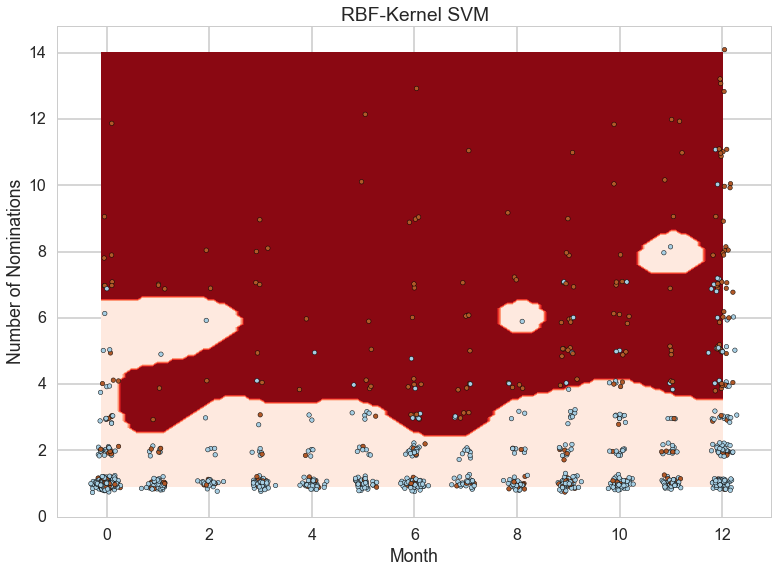

In [131]:
X_imp = dftouse[['month','numnominations']].values
Y = dftouse.winner.values

classifiers = [clf_randomforest,
               clf_adaboost,
               clf_linsvm,
               clf_rbfsvm]

titleClassifer = ['Random Forest Classifier','AdaBoost Classifier', 
                  'Linear SVM', 'RBF-Kernel SVM']
for c in xrange(4):
    plt.title(titleClassifer[c])
    plt.xlabel('Month')
    plt.ylabel('Number of Nominations')
    plot_decision_surface(classifiers[c], X_imp, dftouse.winner.values)

Not surprisingly, as the number of nominations increases, so does the probability of winning an Oscar.  

We found it interesting that in the Random Forest Decision Surface that the films released in the later months had to get more nominations in order to increase their probability of winning an Oscar.  It may be that the most prestigious filmmakers are releasing their movies later in the year and therefore winning an Oscar is more competitive.  

We also thought that plotting the Decision Surface was useful in seeing if our classifiers were overfitting.  RBF-Kernel SVM for example clearly is overfitting for a few movies.  Such overfitting indicates this may not be a good classifier.